In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Text Classification of Movie Reviews

In [2]:
from helpers import Timer

In [3]:
from sklearn.datasets import load_files

reviews_train = load_files("aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target

In [4]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [5]:
reviews_test = load_files("aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


In [6]:
from IPython.display import HTML

In [7]:
print(text_train[1])

Words can't describe how bad this movie is. I can't explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clichés, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won't list them here, but just mention the coloring of the plane. They didn't even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you're choice over this one, even the "Turbulence"-movies are b

In [8]:
HTML(text_train[1461])

In [9]:
print(y_train[1])

0


### Bag of words reminder:

<img src="bag_of_words.svg" width=80%>

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

In [11]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

[u'00', u'000', u'0000000000001', u'00001', u'00015', u'000s', u'001', u'003830', u'006', u'007', u'0079', u'0080', u'0083', u'0093638', u'00am', u'00pm', u'00s', u'01', u'01pm', u'02', u'020410', u'029', u'03', u'04', u'041', u'05', u'050', u'06', u'06th', u'07', u'08', u'087', u'089', u'08th', u'09', u'0f', u'0ne', u'0r', u'0s', u'10', u'100', u'1000', u'1000000', u'10000000000000', u'1000lb', u'1000s', u'1001', u'100b', u'100k', u'100m']
[u'pincher', u'pinchers', u'pinches', u'pinching', u'pinchot', u'pinciotti', u'pine', u'pineal', u'pineapple', u'pineapples', u'pines', u'pinet', u'pinetrees', u'pineyro', u'pinfall', u'pinfold', u'ping', u'pingo', u'pinhead', u'pinheads', u'pinho', u'pining', u'pinjar', u'pink', u'pinkerton', u'pinkett', u'pinkie', u'pinkins', u'pinkish', u'pinko', u'pinks', u'pinku', u'pinkus', u'pinky', u'pinnacle', u'pinnacles', u'pinned', u'pinning', u'pinnings', u'pinnochio', u'pinnocioesque', u'pino', u'pinocchio', u'pinochet', u'pinochets', u'pinoy', u'pinpo

In [12]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<type 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [13]:
print(text_train[19726])

This movie is terrible but it has some good effects.


In [14]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150, 66562], dtype=int32)

In [15]:
X_test = cv.transform(text_test)

In [16]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

with Timer():
    svm.fit(X_train, y_train)

Elapsed: 6s


In [17]:
svm.score(X_train, y_train)

1.0

In [18]:
svm.score(X_test, y_test)

0.84584000000000004

In [19]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


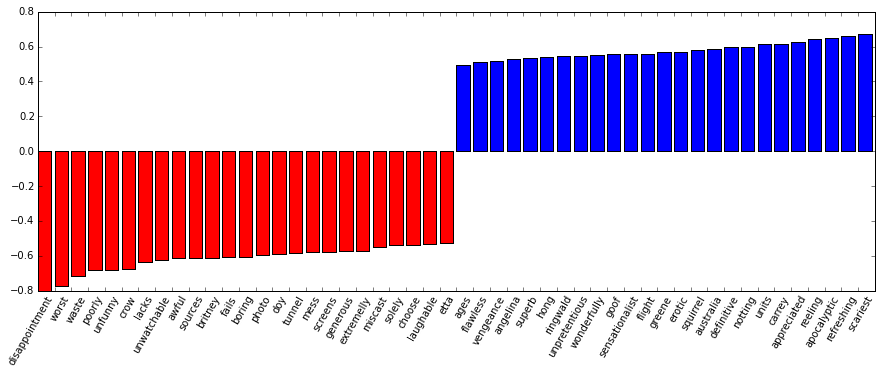

In [20]:
visualize_coefficients(svm, cv.get_feature_names())

In [23]:
from sklearn.pipeline import make_pipeline
text_pipe = make_pipeline(CountVectorizer(), LinearSVC())
text_pipe.fit(text_train, y_train)
text_pipe.score(text_test, y_test)

0.84592000000000001

In [24]:
from sklearn.grid_search import GridSearchCV

param_grid = {'linearsvc__C': np.logspace(-5, 0, 6)}
grid = GridSearchCV(text_pipe, param_grid, cv=5)
with Timer():
    grid.fit(text_train, y_train);

Elapsed: 3m 28s


{'linearsvc__C': 0.01}

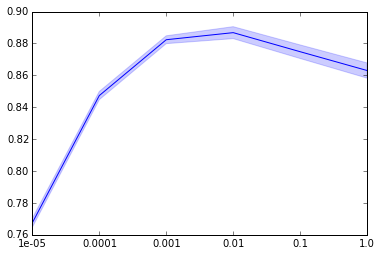

In [25]:
from figures import plot_grid_1d
plot_grid_1d(grid)

grid.best_params_

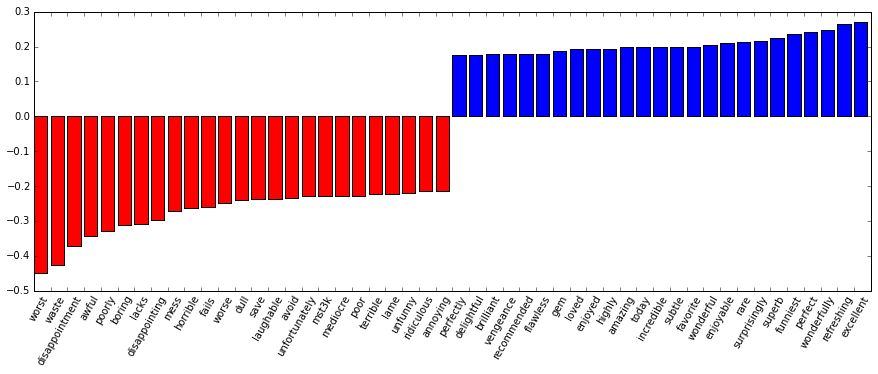

In [26]:
visualize_coefficients(grid.best_estimator_.named_steps['linearsvc'],
                       grid.best_estimator_.named_steps['countvectorizer'].get_feature_names())

In [27]:
grid.best_score_

0.88680000000000003

In [28]:
grid.score(text_test, y_test)

0.87587999999999999

# Text Classification continuation.

## TfidfVectorizer

Elapsed: 2m 58s


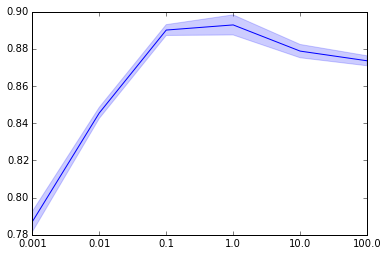

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_pipe = make_pipeline(TfidfVectorizer(), LinearSVC())

param_grid = {'linearsvc__C': np.logspace(-3, 2, 6)}
grid = GridSearchCV(tfidf_pipe, param_grid, cv=5)
with Timer():
    grid.fit(text_train, y_train)
plot_grid_1d(grid)

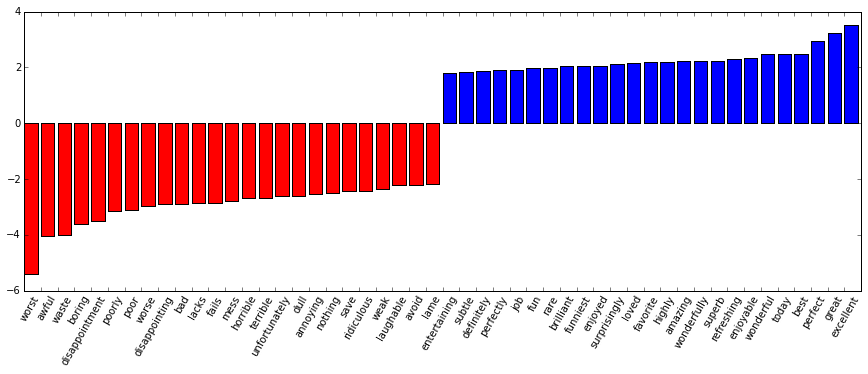

In [30]:
visualize_coefficients(grid.best_estimator_.named_steps['linearsvc'],
                       grid.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names())

In [31]:
grid.best_score_

0.89283999999999997

In [32]:
grid.score(text_test, y_test)

0.87719999999999998

# N-Grams

In [33]:
text_pipe = make_pipeline(CountVectorizer(), LinearSVC())

param_grid = {'linearsvc__C': np.logspace(-3, 2, 6),
              "countvectorizer__ngram_range": [(1, 1), (1, 2)]}

grid = GridSearchCV(text_pipe, param_grid, cv=5)

with Timer():
    grid.fit(text_train, y_train)

Elapsed: 21m 25s


<matplotlib.colorbar.Colorbar instance at 0x7fbeff642fc8>

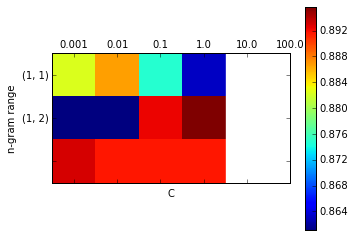

In [34]:
scores = np.array([score.mean_validation_score for score in grid.grid_scores_]).reshape(3, -1)
plt.matshow(scores)
plt.ylabel("n-gram range")
plt.yticks(range(3), param_grid["countvectorizer__ngram_range"])
plt.xlabel("C")
plt.xticks(range(6), param_grid["linearsvc__C"]);
plt.colorbar()

In [35]:
grid.best_params_

{'countvectorizer__ngram_range': (1, 2), 'linearsvc__C': 0.01}

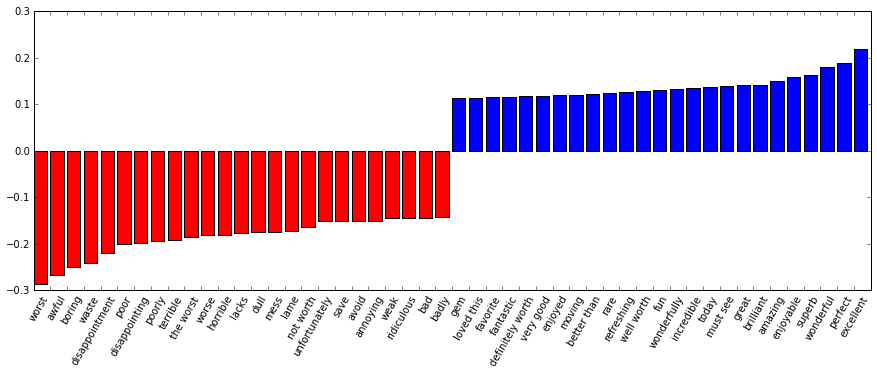

In [36]:
visualize_coefficients(grid.best_estimator_.named_steps['linearsvc'],
                       grid.best_estimator_.named_steps['countvectorizer'].get_feature_names())

In [37]:
grid.score(text_test, y_test)

0.89539999999999997

## Look at the Natural Laguage Tool Kit (NLTK)